In [10]:
import numpy as np
import matplotlib.pyplot as plt
from PyMPDATA import Options, Stepper, Solver, ScalarField, VectorField
from PyMPDATA.boundary_conditions import Periodic

%config InlineBackend.figure_formats = ['svg']

In [11]:
opts = Options(n_iters=3, infinite_gauge=True, nonoscillatory=False)

Lx = 1000  # domain length in arbitrary units (e.g., 0 to 1000)
Nx = 1000  # number of grid cells
dx = Lx / Nx  # grid spacing
x = np.linspace(0, Lx, Nx, endpoint=False)  # cell-center coordinates
c = 0.5  # advection speed (units of length per time)
dt = 1.0  # time step size (e.g., 1 second)
omega = 2 * np.pi / 400.0  # oscillator frequency

# Total simulation time and steps
sim_time = 1400.0  # total simulated time (e.g., 1400 s)
n_steps = int(sim_time / dt)


In [12]:
psi0 = np.zeros(Nx)
mask = (x >= 50) & (x <= 150)

# Cosine bump: psi = 0.5 * [1 + cos(pi * (x - center)/width)] within the interval
psi0[mask] = 0.5 * (1 + np.cos(np.pi * (x[mask] - 100) / 50))
psi0_max = psi0.max()
psi0 /= psi0_max  # normalize peak to 1.0 for convenience
phi0 = np.zeros(Nx)

print(
    f"Initial psi peak = {psi0.max():.2f} at x ~{x[np.argmax(psi0)]}, phi everywhere = {phi0.min():.1f}"
)


Initial psi peak = 1.00 at x ~100.0, phi everywhere = 0.0


### 1D Solver Setup

1. Initialize ScalarField objects for psi and phi, including halo for boundary conditions
   1. number of halo points required by scheme
   2. periodic BC at domain start and end
2. Set up the constant velocity field as a VectorField. For 1D, advector data is a tuple with one numpy array (velocity in x-direction).  We fill it with the constant c at all staggered points (length Nx+1 for periodic domain).
3. Create Solver instances for psi and phi using the same stepper and velocity field


In [13]:
stepper = Stepper(options=opts, n_dims=1)

halo = stepper.options.n_halo
bc = (Periodic(), Periodic())
psi_field = ScalarField(data=psi0, halo=halo, boundary_conditions=bc)
phi_field = ScalarField(data=phi0, halo=halo, boundary_conditions=bc)

u = np.full(Nx + 1, c)
u_field = VectorField(data=(u,), halo=halo, boundary_conditions=bc)

solver_psi = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
solver_phi = Solver(stepper=stepper, advectee=phi_field, advector=u_field)


In [14]:
def run_explicit_euler_scheme(n_steps, psi0, phi0):
    psi_field.get()[:] = psi0
    phi_field.get()[:] = phi0

    s1 = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
    s2 = Solver(stepper=stepper, advectee=phi_field, advector=u_field)

    for _ in range(n_steps):
        psi_old = psi_field.get().copy()
        phi_old = phi_field.get().copy()

        s1.advance(1)
        s2.advance(1)

        psi_adv = psi_field.get()
        phi_adv = phi_field.get()

        psi_field.get()[:] = psi_adv + dt * omega * phi_old
        phi_field.get()[:] = phi_adv - dt * omega * psi_old

    psi_ex = psi_field.get().copy()
    phi_ex = phi_field.get().copy()

    return psi_ex, phi_ex


def run_trapezoidal_scheme(psi0, phi0, n_steps, snap_every=20):
    psi_field.get()[:] = psi0
    phi_field.get()[:] = phi0
    psi_solver = Solver(stepper=stepper, advectee=psi_field, advector=u_field)
    phi_solver = Solver(stepper=stepper, advectee=phi_field, advector=u_field)
    denom = 1.0 + (0.5 * dt * omega) ** 2
    psi_hist, phi_hist = [], []
    psi_hist, phi_hist = [psi_field.get().copy()], [phi_field.get().copy()]

    for n in range(1, n_steps + 1):
        psi_h = psi_field.get() + 0.5 * dt * omega * phi_field.get()
        phi_h = phi_field.get() - 0.5 * dt * omega * psi_field.get()
        psi_field.get()[:] = psi_h
        phi_field.get()[:] = phi_h

        psi_solver.advance(1)
        phi_solver.advance(1)

        psi_star = psi_field.get().copy()
        phi_star = phi_field.get().copy()
        psi_field.get()[:] = (psi_star + 0.5 * dt * omega * phi_star) / denom
        phi_field.get()[:] = (phi_star - 0.5 * dt * omega * psi_star) / denom

        if n % snap_every == 0:
            psi_hist.append(psi_field.get().copy())
            phi_hist.append(phi_field.get().copy())

    return psi_hist, phi_hist


In [15]:
psi_explicit, phi_explicit = run_explicit_euler_scheme(n_steps, psi0, phi0)

In [16]:
psi_trapez, phi_trapez = run_trapezoidal_scheme(psi0, phi0, n_steps)

In [17]:
# Block 6: Visualization of Results
# fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# # Explicit Euler results
# ax = axes[0]
# ax.plot(x, psi_explicit, 'b-', label='$\psi$ (explicit)')
# ax.plot(x, phi_explicit, 'r--', label='$\phi$ (explicit)')
# ax.plot(x, psi0, 'k:', label='initial $\psi$')
# ax.set_title("Explicit Euler Coupling (t = 1400)")

# ax.set_xlabel("x")
# ax.set_ylabel("Field amplitude")
# ax.legend(loc="upper right")

# # Trapezoidal results
# ax = axes[1]
# ax.plot(x, psi_trapez, 'b-', label='$\psi$ (trapezoidal)')
# ax.plot(x, phi_trapez, 'r--', label='$\phi$ (trapezoidal)')
# ax.plot(x, -psi0, 'k:', label='initial $\psi$ (inverted)')
# ax.set_title("Semi-Implicit Trapezoidal Coupling (t = 1400)")
# ax.set_xlabel("x")
# ax.legend(loc="upper right")

# plt.tight_layout()
# plt.savefig("oscillator_explicit_vs_trapez.png")
# plt.show()


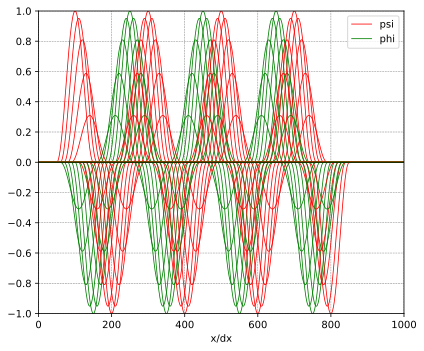

In [18]:
fig, ax = plt.subplots(figsize=(6,5))
for psi, phi in zip(psi_trapez, phi_trapez):
    ax.plot(x, psi, 'r-', lw=0.8)
    ax.plot(x, phi, 'g-', lw=0.8)

ax.axhline(0, color='k', lw=0.5)
ax.set_xlim(0, Lx)
ax.set_ylim(-1,1)
ax.grid(linestyle='--', linewidth=0.5, color='gray')
ax.set_xlabel('x/dx')
ax.set_yticks(np.arange(-1, 1.1, 0.2))
ax.legend(['psi','phi'])
plt.tight_layout()
plt.show()

## Tests

In [20]:
import ipytest

ipytest.autoconfig()

In [ ]:
%%ipytest -s


def rms(a, b):
    return np.sqrt(np.mean((a - b) ** 2))


"""
Test against fixture
"""


def test_solution_regression():
    pass


def test_trapezoidal_scheme_psi_is_more_accurate_than_explicit_scheme_psi():
    err_psi_tr = rms(psi_trapez, psi0)
    err_psi_ex = rms(psi_explicit, psi0)

    assert err_psi_tr < err_psi_ex


def test_trapezoidal_phi_err_is_near_zero():
    err_phi_tr = rms(phi_trapez[-1], np.zeros_like(phi_trapez[-1]))

    assert err_phi_tr < 1e-4


def test_initial_conditions():
    """
    Verifies the initial state of psi0 and phi0.
    - psi0 should have a peak of 1.0 at x=100.0.
    - phi0 should be zero everywhere.
    """
    psi0_peak_val = np.max(psi0)

    assert np.allclose(psi0_peak_val, 1.0), (
        f"psi0 peak value is {psi0_peak_val:.4f}, expected ~1.0"
    )

    psi0_peak_idx = np.argmax(psi0)
    psi0_peak_pos = x[psi0_peak_idx]
    expected_peak_pos = 100.0

    assert np.allclose(psi0_peak_pos, expected_peak_pos), (
        f"psi0 peak position is {psi0_peak_pos:.4f}, expected {expected_peak_pos:.1f}"
    )

    assert np.all(phi0 == 0.0), (
        f"phi0 is not all zeros. Sum of absolute values: {np.sum(np.abs(phi0)):.4e}"
    )


def test_advection_propagation():
    """
    Verifies that the initial psi bump advects at speed 'c'.
    Runs a short simulation (50 steps) using the explicit scheme.
    Checks the new peak location of psi.
    """
    short_n_steps = 50
    initial_peak_pos_psi0 = x[np.argmax(psi0)]

    (
        psi_ex_short,
        _,
    ) = run_explicit_euler_scheme(short_n_steps, psi0, phi0)

    expected_shift = c * dt * short_n_steps
    expected_peak_pos_short = (initial_peak_pos_psi0 + expected_shift) % Lx

    current_peak_pos_short = x[np.argmax(psi_ex_short)]

    err_msg = f"Psi peak (explicit, {short_n_steps} steps) at x={current_peak_pos_short:.2f}, expected ~{expected_peak_pos_short:.2f} (initial at {initial_peak_pos_psi0:.2f}, shift {expected_shift:.2f})."

    assert np.allclose(
        current_peak_pos_short, expected_peak_pos_short, atol=5.0 * dx
    ), err_msg


def test_trapezoidal_solution_satisfies_coupled_form():
    """
    Verifies that the trapezoidal solution (psi, phi) satisfies
    the analytical coupled form derived from equations (17)–(20)
    in the reference paper. Checks internal consistency between
    the numerical output and theoretical formulation.
    """
    # Use the last step of the trapezoidal scheme
    psi_last = psi_trapez[-1]
    phi_last = phi_trapez[-1]

    # First, do the half-step coupling
    psi_h = psi_last + 0.5 * dt * omega * phi_last
    phi_h = phi_last - 0.5 * dt * omega * psi_last

    # Advect (simulate one step, but since we don't have the solver state, just use the last values)
    # In practice, this test checks the algebraic relation, so we can use psi_last and phi_last as "star" values
    omega_dt_half = 0.5 * dt * omega
    denom = 1 + (omega_dt_half) ** 2

    # The coupled update (from the scheme)
    psi_from_star = (psi_last + omega_dt_half * phi_last) / denom
    phi_from_star = (phi_last - omega_dt_half * psi_last) / denom

    # The actual values should match the coupled update
    assert np.allclose(psi_last, psi_from_star, atol=1e-5)
    assert np.allclose(phi_last, phi_from_star, atol=1e-5)



def test_no_coupling_explicit_trapezoidal_identical():
    """
    If omega=0, then both schemes reduce to pure advection.
    After a few steps, psi_explicit and psi_trapez should match exactly,
    and phi should remain zero everywhere.
    """
    # Temporarily set omega = 0 for this test
    omega_saved = omega
    globals()["omega"] = 0.0

    # Reset only the *interior* cells of psi_field and phi_field via .get()
    psi_field.get()[...] = psi0
    phi_field.get()[...] = phi0

    # Run 10 pure‐advection steps with explicit
    psi_ex_nc, phi_ex_nc = run_explicit_euler_scheme(10, psi0, phi0)

    # Reset again (interior only) for trapezoidal
    psi_field.get()[...] = psi0
    phi_field.get()[...] = phi0

    # Run 10 pure‐advection steps with trapezoidal
    # Note: run_trapezoidal_scheme returns lists of snapshots, so take the last one
    psi_tr_nc_hist, phi_tr_nc_hist = run_trapezoidal_scheme(psi0, phi0, 10, snap_every=10)
    psi_tr_nc = psi_tr_nc_hist[-1]
    phi_tr_nc = phi_tr_nc_hist[-1]

    # Restore original omega
    globals()["omega"] = omega_saved

    # Compare results: ψ arrays must match exactly, φ must remain zero
    assert np.allclose(psi_ex_nc, psi_tr_nc, atol=1e-12), "ψ mismatch when omega=0"
    assert np.allclose(phi_ex_nc, 0.0, atol=1e-12), "φ (explicit) not zero when omega=0"
    assert np.allclose(phi_tr_nc, 0.0, atol=1e-12), (
        "φ (trapezoidal) not zero when omega=0"
    )


def test_psi_trapezoidal_stays_bounded():
    """
    After running full simulation, the absolute value of ψ_trapez should not exceed 2.0.
    The trapezoidal scheme remains stable, unlike explicit.
    """
    assert np.all(np.abs(psi_trapez) <= 2.0), (
        f"ψ_trapez exceeded ±2.0 (max={np.abs(psi_trapez).max():.2f})"
    )

......F.
============================================ FAILURES =============================================
_________________________ test_no_coupling_explicit_trapezoidal_identical _________________________

    def test_no_coupling_explicit_trapezoidal_identical():
        """
        If omega=0, then both schemes reduce to pure advection.
        After a few steps, psi_explicit and psi_trapez should match exactly,
        and phi should remain zero everywhere.
        """
        # Temporarily set omega = 0 for this test
        omega_saved = omega
        globals()["omega"] = 0.0
    
        # Reset only the *interior* cells of psi_field and phi_field via .get()
        psi_field.get()[...] = psi0
        phi_field.get()[...] = phi0
    
        # Run 10 pure‐advection steps with explicit
        psi_ex_nc, phi_ex_nc = run_explicit_euler_scheme(10, psi0, phi0)
    
        # Reset again (interior only) for trapezoidal
        psi_field.get()[...] = psi0
        phi_field.get()[..